***
# PREVISÃO DE VENDAS - REDE DE DROGARIAS 
***

## CONTEXTUALIZAÇÃO DO PROJETO:
***

O CFO da rede de drogarias solicitou uma previsão de vendas com o objetivo de obter informações precisas sobre o desempenho das lojas da rede e determinar o valor do investimento necessário para reformar cada uma das lojas. Utilizaremos um conjunto de dados históricos de vendas diárias que abrangem um período de dois anos e meio para fazer previsões de vendas diárias para as 1.115 lojas da rede localizadas em diferentes partes da Alemanha para os próximos 42 dias. Essas previsões fornecerão informações sobre o valor total das vendas esperadas em cada loja, bem como como essas vendas serão distribuídas diariamente. O objetivo final é fornecer informações confiáveis que permitam que a empresa tome decisões informadas sobre o investimento em reformas nas lojas.

**Premissas do negócio:**
    
    1. Foram consideradas para a previsão apenas as lojas que possuem o valor de vendas superior a 0 na base de dados.

    2. Os dias em que as lojas estavam fechadas foram descartadas na realização da previsão.
   

*O contexto, pessoas e perguntas são completamente fictícios.* O dataset utilizado para o projeto está disponível no [Kaggle](https://www.kaggle.com/competitions/rossmann-store-sales/data).

**SUMÁRIO DA ANÁLISE**


**1. IMPORTS DE LIBRARIES E DATASET**

**2. DESCRIÇÃO DO DATASET**
    
**4. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)**
   
    Hipóteses sobre os problemas definidos analisando visualmente os dados.
    1. Quais são as variáveis que impactam o fenômeno que estamos modelando?
    2. O que faz a venda diminuir e aumentar? 
    3. Verificar forças das correlações
    
**3. DATA CLEANING**
        
    Verificar as inconsistências nos dados, lidar com valores ausentes e tratar os dados.

**5. FEATURE ENGINEERING**
    
    Seleção das features importantes e construção de outras features mais significativas usando os dados brutos.
    
**6. MACHINE LEARNING**
    
**7. CONCLUSÃO DO PROJETO E PERSPECTIVAS**


# LOADING LIBRARIES

In [99]:
import pandas as pd
import inflection
import math
import numpy as np
import datetime
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from dython.nominal import associations
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)
import sidetable as stb

In [100]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [183]:
plt.rcParams['figure.figsize'] = [12, 5]

# FUNÇÕES AUXILIARES

# LOADING DATASET

In [101]:
# Dados históricos, incluindo a target vendas
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)

# Informações complementares sobre as lojas
df_store_raw = pd.read_csv('../data/raw/store.csv')

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, on='Store', how='left')

# EXPLORAÇÃO DO DATASET 

In [4]:
print('Número de linhas:{}'.format(df_raw.shape[0]))
print('Número de colunas:{}'.format(df_raw.shape[1]))

Número de linhas:1017209
Número de colunas:18


In [5]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


In [6]:
df_raw.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.00,6.00,2014.00,1,31.00,2013.00,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.00,4.00,2006.00,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.00,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.00,NaN,NaN,0,NaN,NaN,NaN
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.00,NaN,NaN,1,22.00,2012.00,"Mar,Jun,Sept,Dec"


## Descrição das colunas do dataset

In [7]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

 Variável | Descrição
:------------|:---------
Store | ID exclusivo para cada loja
Sales | O volume de vendas de um determinado dia (variável que será prevista)
Customers | Número de clientes em um determinado dia
Open | Indicador para funcionamento da loja, aberta: 0 = fechada e 1 = aberta
StateHoliday | Feriado estadual. Normalmente todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais. Todas as escolas estão fechadas nos feriados e fins de semana. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday | Indica se store e date foram afetadas pelo fechamento de escolas públicas
StoreType | Diferencia entre os 4 modelos de loja diferentes (a, b, c, d)
Assortment | Descreve um nível de sortimento (a = basic, b = extra, c = extended)
Competition_distance | Distância em metros até a loja concorrente mais próxima
Competition_open_since (_month/_year) | Fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto
Promo | Indica se uma loja está realizando uma promoção naquele dia (0 = store is not participating, 1 = store is participating)
Promo2 | Promo2 é uma promoção contínua e consecutiva para algumas lojas (0 = store is not participating, 1 = store is participating)
Promo2_since(_year/_week) | Descreve o ano e a semana do calendário em que a loja começou a participar da promo2
Promo_interval | Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente. E.g: "Feb,May,Aug,Nov" significa que cada rodada começa em February, May, August, November de qualquer ano para essa loja.

## Análise da qualidade dos dados

In [8]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.00,558.43,321.91,1.00,280.00,558.00,838.00,1115.00
DayOfWeek,1017209.00,4.00,2.00,1.00,2.00,4.00,6.00,7.00
Sales,1017209.00,5773.82,3849.93,0.00,3727.00,5744.00,7856.00,41551.00
Customers,1017209.00,633.15,464.41,0.00,405.00,609.00,837.00,7388.00
Open,1017209.00,0.83,0.38,0.00,1.00,1.00,1.00,1.00
Promo,1017209.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
SchoolHoliday,1017209.00,0.18,0.38,0.00,0.00,0.00,0.00,1.00
CompetitionDistance,1014567.00,5430.09,7715.32,20.00,710.00,2330.00,6890.00,75860.00
CompetitionOpenSinceMonth,693861.00,7.22,3.21,1.00,4.00,8.00,10.00,12.00
CompetitionOpenSinceYear,693861.00,2008.69,5.99,1900.00,2006.00,2010.00,2013.00,2015.00


## Tipos de dados e conversão de tipo

In [9]:
df_raw.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [121]:
# Converter 'Date' para datetime
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

In [11]:
# Check
df_raw.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## Dados ausentes

In [12]:
df_raw.stb.missing()

,missing,total,percent
PromoInterval,508031,1017209,49.94
Promo2SinceYear,508031,1017209,49.94
Promo2SinceWeek,508031,1017209,49.94
CompetitionOpenSinceYear,323348,1017209,31.79
CompetitionOpenSinceMonth,323348,1017209,31.79
CompetitionDistance,2642,1017209,0.26
DayOfWeek,0,1017209,0.00
Promo2,0,1017209,0.00
Assortment,0,1017209,0.00
Store,0,1017209,0.00


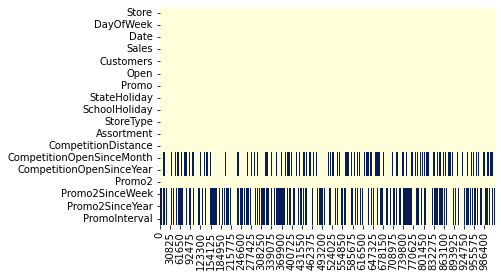

In [13]:
# Visualizando a distribuição dos missing values
sns.heatmap(df_raw.isnull().transpose(), cmap='YlGnBu', cbar=False);

**O gráfico mostra visualmente que:**

- Metade dos valores em Promo2SinceWeek, Promo2SinceYear e PromoInterval estão ausentes.
- As colunas relacionadas a CompetitionOpenSinceMonth e CompetitionOpenSinceYear têm mais de 30% de valores ausentes.  
- Outra maneira de lidar com isso é examinar a importância desses valores ausentes em comparação com o tamanho real dos dados.

## Novas variáveis a partir da feature 'Date'

In [167]:
df1 = df_raw.copy()

In [168]:
# Year
df1['Year'] = df1['Date'].dt.year

# Month
df1['Month'] = df1['Date'].dt.month

# Day
df1['Day'] = df1['Date'].dt.day

# Week of year
df1['WeekOfYear'] = df1['Date'].dt.isocalendar().week

# Year Week
df1['YearWeek'] = df1['Date'].dt.strftime('%Y-%W')

## Filtragem dos dados

A partir da análise da tabela com a descrição das variáveis, podemos observar que 
existem valores registrados como 0 para **Sales**, **Customers** e **Open**.

    1 - Quantas lojas estão fechadas?
    2 - Quantas lojas apresentaram valor de Sales = 0?
    3 - Quantas lojas apresentaram valor de Customers = 0?

In [17]:
store_closed = len(df1.query('Open == 0'))                             
print(f"1. Temos {store_closed} lojas fechadas.")

sales_0 = len(df1.query('Sales == 0'))
print(f"2. Temos {sales_0} lojas com vendas registradas como 0.")

customers_0 = len(df1.query('Customers == 0'))
print(f"3. Temos {customers_0} lojas com 0 clientes.")

1. Temos 172817 lojas fechadas.
2. Temos 172871 lojas com vendas registradas como 0.
3. Temos 172869 lojas com 0 clientes.


In [27]:
df1[['Open', 'StateHoliday', 'SchoolHoliday', 'Sales', 'Customers']
    ].groupby(['Open', 'StateHoliday', 'SchoolHoliday']).agg({'Sales': ['mean'], 'Customers': ['mean']}).stb.flatten()

,Open,StateHoliday,SchoolHoliday,Sales_mean,Customers_mean
0,0,0,0,0.00,0.00
1,0,0,1,0.00,0.00
2,0,a,0,0.00,0.00
3,0,a,1,0.00,0.00
4,0,b,0,0.00,0.00
5,0,b,1,0.00,0.00
6,0,c,1,0.00,0.00
7,1,0,0,6895.15,757.35
8,1,0,1,7196.90,781.77
9,1,a,0,8492.07,1266.11


In [28]:
df1[['Open', 'StoreType', 'Assortment', 'Sales', 'Customers']
    ].groupby(['Open', 'StoreType', 'Assortment']).agg({'Sales': ['mean'], 'Customers': ['mean']}).stb.flatten()

,Open,StoreType,Assortment,Sales_mean,Customers_mean
0,0,a,a,0.00,0.00
1,0,a,c,0.00,0.00
2,0,b,a,0.00,0.00
3,0,b,b,0.00,0.00
4,0,c,a,0.00,0.00
5,0,c,c,0.00,0.00
6,0,d,a,0.00,0.00
7,0,d,c,0.00,0.00
8,1,a,a,6537.62,759.24
9,1,a,c,7573.38,855.77


- Como premissa não consideraremos os dias com as lojas fechadas, ou seja, 'Open' == 0.

In [139]:
# Filtragem
df1 =  df_raw.loc[(df_raw['Open'] != 0)]

In [141]:
print('Número de linhas:{}'.format(df1.shape[0]))
print('Número de colunas:{}'.format(df1.shape[1]))

Número de linhas:844392
Número de colunas:18


# ANÁLISE EXPLORATÓRIA DE DADOS

    Diversos fatores podem influenciar o desempenho das vendas de uma rede de drogarias em lojas físicas. 
    Como as expostas na imagem abaixo:

![Map hipoteses](../img/mind_map.jpg "Mapa Mental")

**HIPÓTESES**

**Clientes**

    a. As vendas podem ser diferentes dependendo do perfil dos clientes, como a faixa etária ou o 
    nível socioeconômico.
    b. Um maior número de clientes em uma determinada loja ou período resulta em mais vendas.
    
**Produtos**

    a. As vendas podem aumentar durante campanhas de marketing e promoções, como liquidações de estoque 
    ou descontos em compras.
    b. Um maior sortimento de produtos pode atrair diferentes tipos de clientes e aumentar a probabilidade
    de encontrar produtos que atendam às necessidades dos clientes. Em consequência, isso pode levar a um 
    aumento nas vendas.

**Localização da loja**

    a. As vendas podem ser afetadas pela presença de concorrentes nas proximidades ou pela abertura de novas
    lojas na região.
    b. As vendas podem variar dependendo da localização das lojas, como em áreas urbanas com alta densidade 
    populacional ou em bairros residenciais.
    
**Temporalidade**
    
    a. Dia da semana: as vendas podem ser maiores em certos dias da semana, como sexta-feira ou sábado, devido ao 
    aumento do tráfego de compradores nos finais de semana.
    b. Estação do ano: as vendas podem ser influenciadas por mudanças sazonais, como o aumento das vendas de protetor 
    solar no verão ou de vitaminas e remédios no inverno.
    c. Feriados também podem influenciar as vendas, com um aumento esperado nas vendas durante feriados como Natal.

## Estatística descritiva

In [72]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### Features numéricas

In [73]:
# Medidas de tendência central e dispersão
num_attributes.agg(['mean', 'median', 'std', 'min', 'max', 'ptp', 'skew',
                   'kurtosis']).T.reset_index().rename(columns={'index': 'Attributes', 'ptp': 'range'})

,Attributes,mean,median,std,min,max,range,skew,kurtosis
0,Store,558.42,558.00,321.73,1.00,1115.00,1114.00,0.00,-1.20
1,DayOfWeek,3.52,3.00,1.72,1.00,7.00,6.00,0.02,-1.26
2,Sales,6955.96,6369.00,3103.82,46.00,41551.00,41505.00,1.59,4.85
3,Customers,762.78,676.00,401.19,8.00,7388.00,7380.00,2.79,13.32
4,Open,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00
5,Promo,0.45,0.00,0.50,0.00,1.00,1.00,0.22,-1.95
6,SchoolHoliday,0.19,0.00,0.40,0.00,1.00,1.00,1.55,0.41
7,CompetitionDistance,5458.16,2320.00,7809.57,20.00,75860.00,NaN,2.98,13.41
8,CompetitionOpenSinceMonth,7.22,8.00,3.21,1.00,12.00,NaN,-0.17,-1.25
9,CompetitionOpenSinceYear,2008.70,2010.00,5.98,1900.00,2015.00,NaN,-7.52,121.85


### Features categóricas

In [74]:
cat_attributes.head()

,StateHoliday,StoreType,Assortment,PromoInterval
0,0,c,a,NaN
1,0,a,a,"Jan,Apr,Jul,Oct"
2,0,a,a,"Jan,Apr,Jul,Oct"
3,0,c,c,NaN
4,0,a,a,NaN


In [75]:
# Número de valores exclusivos para cada variável categórica
cat_attributes.nunique()

StateHoliday     4
StoreType        4
Assortment       3
PromoInterval    3
dtype: int64

In [76]:
# StateHoliday pode assumir os seguintes valores: 
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df1.stb.freq(['StateHoliday'])

,StateHoliday,count,percent,cumulative_count,cumulative_percent
0,0,843428,99.89,843428,99.89
1,a,694,0.08,844122,99.97
2,b,145,0.02,844267,99.99
3,c,71,0.01,844338,100.00


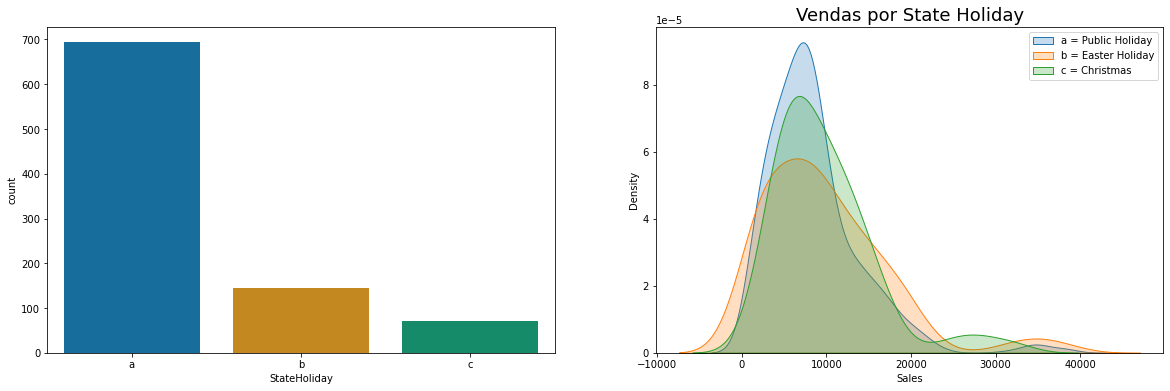

In [115]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))
hollidays = df1[df1['StateHoliday'] != '0']

# StateHoliday
sns.countplot(hollidays['StateHoliday'], palette='colorblind', ax=ax0)

# Kde
sns.kdeplot(df1[df1['StateHoliday'] == 'a']
            ['Sales'], label='a = Public Holiday', shade=True, ax=ax1)

sns.kdeplot(df1[df1['StateHoliday'] == 'b']
            ['Sales'], label='b = Easter Holiday', shade=True, ax=ax1)

sns.kdeplot(df1[df1['StateHoliday'] == 'c']
            ['Sales'], label='c = Christmas', shade=True, ax=ax1);
ax1.set_title('Vendas por State Holiday', fontsize=18)
ax1.legend()

In [78]:
# SchoolHoliday pode assumir os seguintes valores: 
# 0= não ou 1= sim
df1.stb.freq(['SchoolHoliday'])

,SchoolHoliday,count,percent,cumulative_count,cumulative_percent
0,0,680893,80.64,680893,80.64
1,1,163445,19.36,844338,100.00


C:\Users\Lidiane\anaconda3\envs\ds_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


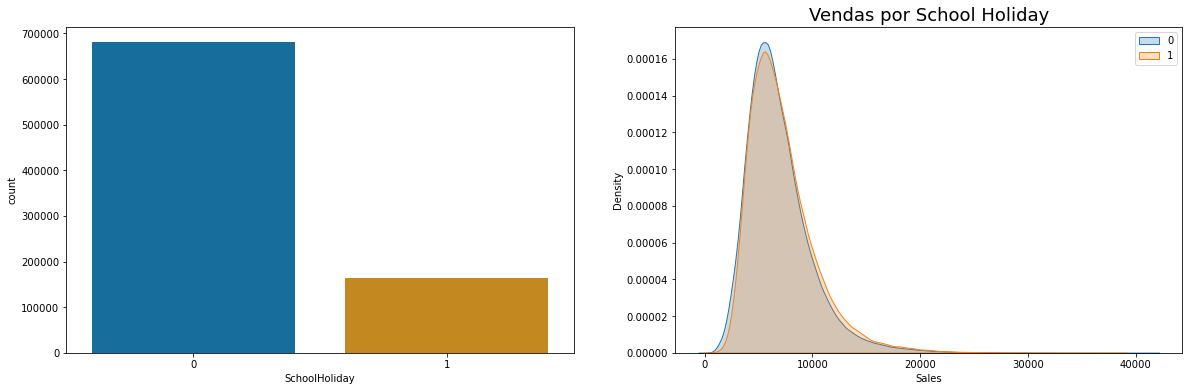

In [93]:
# Store Type
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

sns.countplot(df1['SchoolHoliday'], palette='colorblind', ax=ax0)

sns.kdeplot(df1[df1['SchoolHoliday'] == 0]['Sales'],
            label='0', shade=True, ax=ax1)
sns.kdeplot(df1[df1['SchoolHoliday'] == 1]['Sales'],
            label='1', shade=True, ax=ax1)
ax1.set_title('Vendas por School Holiday', fontsize=18)
ax1.legend()

In [79]:
# StoreType pode assumir os valores a, b, c ou d.
df1.stb.freq(['StoreType'])

,StoreType,count,percent,cumulative_count,cumulative_percent
0,a,457042,54.13,457042,54.13
1,d,258768,30.65,715810,84.78
2,c,112968,13.38,828778,98.16
3,b,15560,1.84,844338,100.00


C:\Users\Lidiane\anaconda3\envs\ds_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


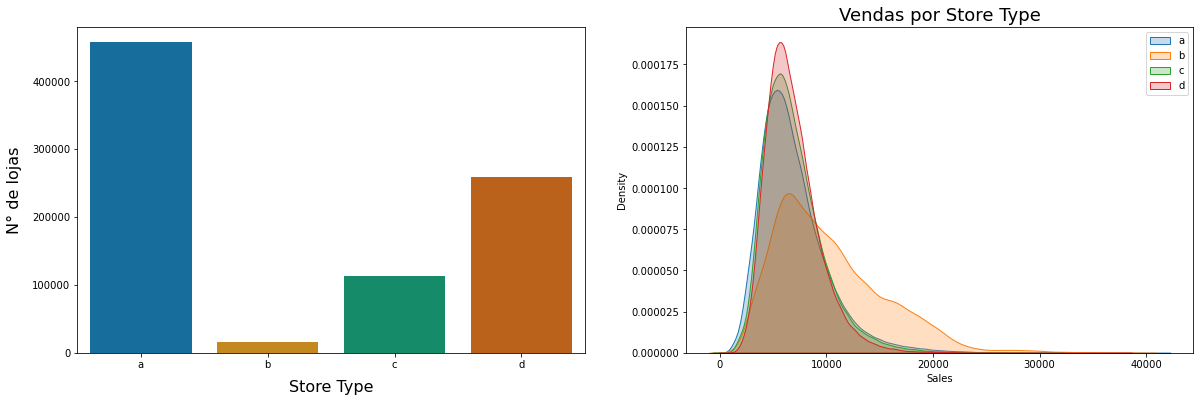

In [105]:
# Store Type
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

sns.countplot(df1['StoreType'], palette='colorblind', order=['a', 'b', 'c', 'd'],ax=ax0)
ax0.set_xlabel('Store Type', labelpad=10, fontsize=16)
ax0.set_ylabel('N° de lojas', labelpad=10, fontsize=16)

sns.kdeplot(df1[df1['StoreType'] == 'a']['Sales'],
            label='a', shade=True, ax=ax1)

sns.kdeplot(df1[df1['StoreType'] == 'b']['Sales'],
            label='b', shade=True,ax=ax1)
sns.kdeplot(df1[df1['StoreType'] == 'c']['Sales'],
            label='c', shade=True, ax=ax1)
sns.kdeplot(df1[df1['StoreType'] == 'd']['Sales'],
            label='d', shade=True, ax=ax1)
ax1.set_title('Vendas por Store Type', fontsize=18)
ax1.legend();

In [82]:
# Assortment descreve um nível de sortimento da loja.
# a = basic, b = extra, c = extended
df1.stb.freq(['Assortment'])

,Assortment,count,percent,cumulative_count,cumulative_percent
0,a,444875,52.69,444875,52.69
1,c,391254,46.34,836129,99.03
2,b,8209,0.97,844338,100.00


C:\Users\Lidiane\anaconda3\envs\ds_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


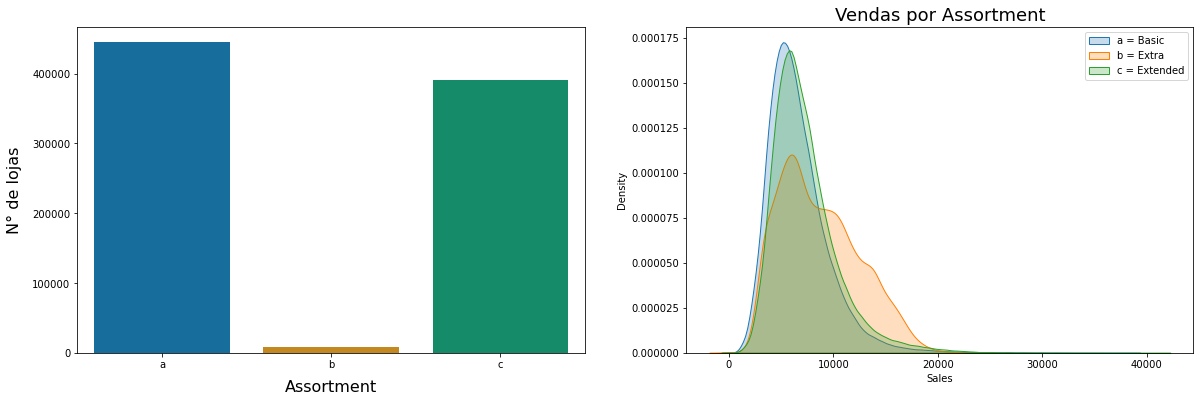

In [156]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

sns.countplot(df1['Assortment'], palette='colorblind',
              order=['a', 'b', 'c'], ax=ax0)
ax0.set_xlabel('Assortment', labelpad=10, fontsize=16)
ax0.set_ylabel('N° de lojas', labelpad=10, fontsize=16)

sns.kdeplot(df1[df1['Assortment'] == 'a']['Sales'],
            label='a = Basic', shade=True, color='#1f77b4', ax=ax1)
sns.kdeplot(df1[df1['Assortment'] == 'b']['Sales'],
            label='b = Extra', shade=True, color='#ff7f02', ax=ax1)
sns.kdeplot(df1[df1['Assortment'] == 'c']['Sales'],
            label='c = Extended', shade=True, color='#2ca02c', ax=ax1)
ax1.set_title('Vendas por Assortment', fontsize=18)
ax1.legend()

## Histograma das variáveis numéricas: Vendas, Número de Clientes e Distância do Concorrente

In [146]:
df1.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,844392.00,842206.00,575773.00,575773.00,844392.00,421085.00,421085.00
mean,558.42,3.52,6955.51,762.73,1.00,0.45,0.19,5457.98,7.22,2008.70,0.50,23.25,2011.75
std,321.73,1.72,3104.21,401.23,0.00,0.50,0.40,7809.44,3.21,5.98,0.50,14.10,1.66
min,1.00,1.00,0.00,0.00,1.00,0.00,0.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,280.00,2.00,4859.00,519.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,3.00,6369.00,676.00,1.00,0.00,0.00,2320.00,8.00,2010.00,0.00,22.00,2012.00
75%,837.00,5.00,8360.00,893.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.00,50.00,2015.00


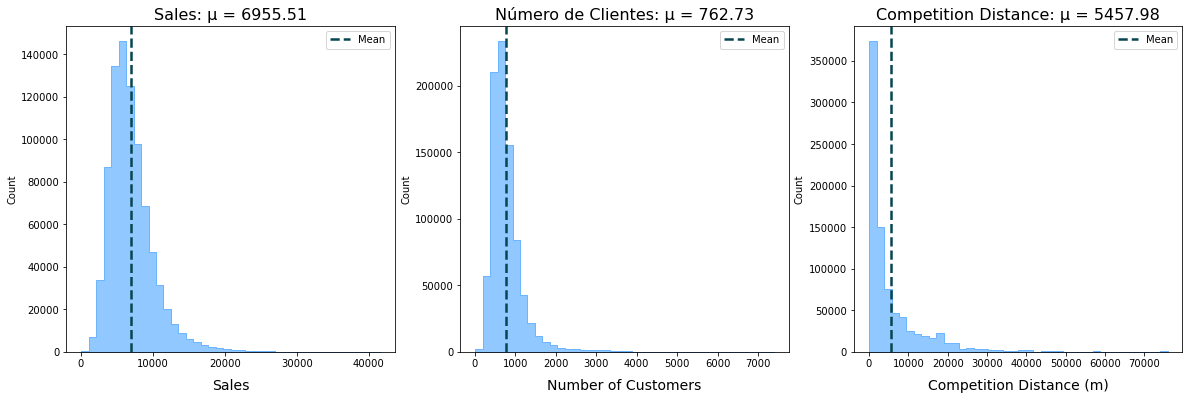

In [152]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                    figsize=(20, 6))
# Sales
sns.histplot(num_attributes.Sales, bins=40, element='step',
             color='#6DB6FF', ax=ax0)
ax0.set_xlabel('Sales', labelpad=10, fontsize=14)
ax0.axvline(x=num_attributes.Sales.mean(),
            label='Mean', color='#074650', ls='--', lw=2.5)
ax0.set_title('Sales: μ = 6955.51', fontsize=16)
ax0.legend()

# Customers
sns.histplot(num_attributes.Customers, bins=40, element='step',
             color='#6DB6FF', ax=ax1)
ax1.set_xlabel('Number of Customers', labelpad=10, fontsize=14)
ax1.axvline(x=num_attributes.Customers.mean(),
            label='Mean', color='#074650', ls='--', lw=2.5)
ax1.set_title('Número de Clientes: μ = 762.73', fontsize=16)
ax1.legend()

# Competition Distance
sns.histplot(num_attributes.CompetitionDistance, element='step',
             bins=40, color='#6DB6FF', ax=ax2)
ax2.set_xlabel('Competition Distance (m)', labelpad=10, fontsize=14)
ax2.axvline(x=num_attributes.CompetitionDistance.mean(),
            label='Mean', color='#074650', ls='--', lw=2.5)
ax2.set_title('Competition Distance: μ = 5457.98', fontsize=16)
ax2.legend()

## Lojas com maior sortimento apresentam maiores valores de venda.

   Um maior sortimento de produtos pode atrair diferentes tipos de clientes e aumentar a probabilidade de 
   encontrar produtos que atendam às necessidades dos clientes. Em consequência, isso pode levar a um  aumento 
   nas vendas.
   
   Em contrapartida, as lojas com sortimento b = extra ou c = extended não apresentaram um volume de vendas maior 
   quando comparadas as lojas de sortimento a = basic.

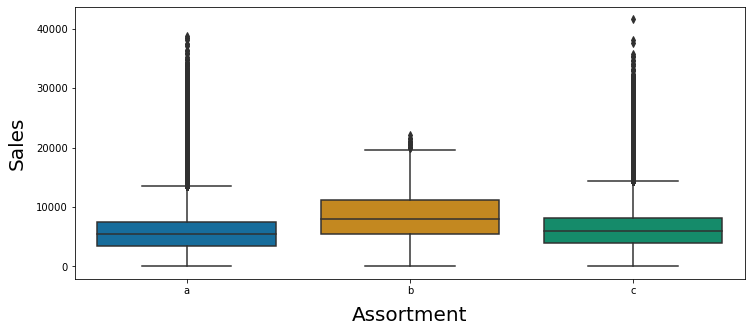

In [184]:
# Boxplot para comparar as vendas por tipo de sortimento
sns.boxplot(x='Assortment', y='Sales', data=df1, palette='colorblind', order=['a', 'b', 'c'])
plt.xlabel('Assortment', labelpad=10, fontsize=20)
plt.ylabel('Sales', labelpad= 10, fontsize=20);

**Há variação das vendas por sortimento ao longo dos anos?**

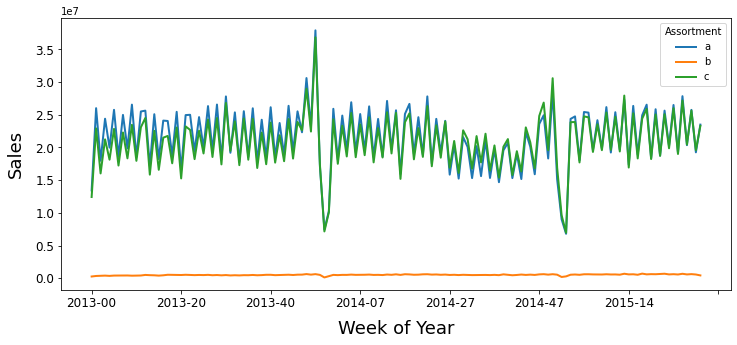

In [186]:
# Gráfico Temporal para demonstrar a variação das vendas por sortimento ao longo dos anos
aux = df1[['YearWeek', 'Assortment', 'Sales']].groupby(
    ['YearWeek', 'Assortment']).sum().reset_index()
aux.pivot(index='YearWeek', columns='Assortment',
          values='Sales').plot(fontsize=12, linewidth=2)
plt.xlabel('Week of Year', labelpad=10, fontsize=18)
plt.ylabel('Sales', labelpad=10, fontsize=18);

Text(0, 0.5, 'Sales')

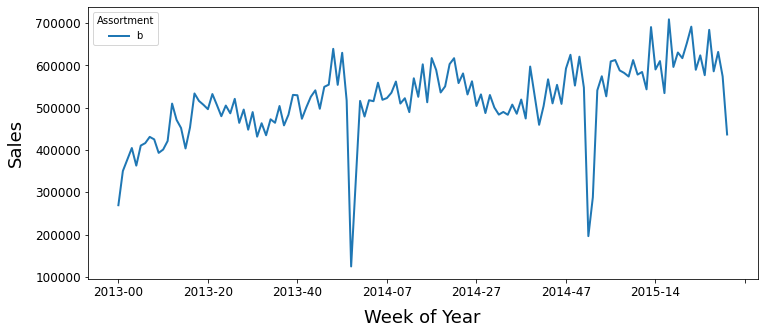

In [192]:
# Gráfico Temporal para mostrar a variação das vendas quando o sortimento for igual a b = extra
aux1 = aux[aux['Assortment'] == 'b']
aux1.pivot(index='YearWeek', columns='Assortment',
           values='Sales').plot(fontsize=12, linewidth=2)
plt.xlabel('Week of Year', labelpad=10, fontsize=18)
plt.ylabel('Sales', labelpad=10, fontsize=18);

## Lojas com competidores mais próximos vendem menos

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Sales'>

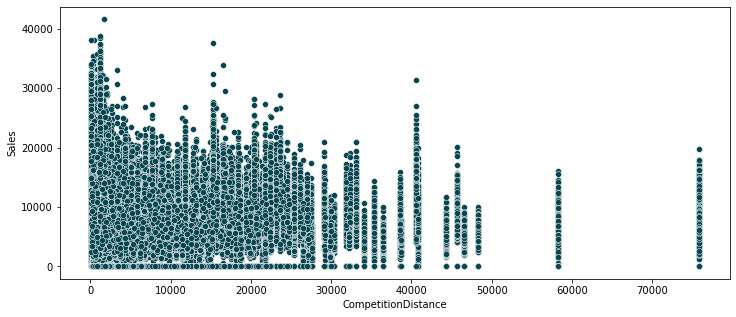

In [205]:
# Gráfico de Distribuição de ponto para verificarmos a distribuição das vendas em relação a distancia do competidor
sns.scatterplot(x='CompetitionDistance', y='Sales', color='#074650', data=df1);

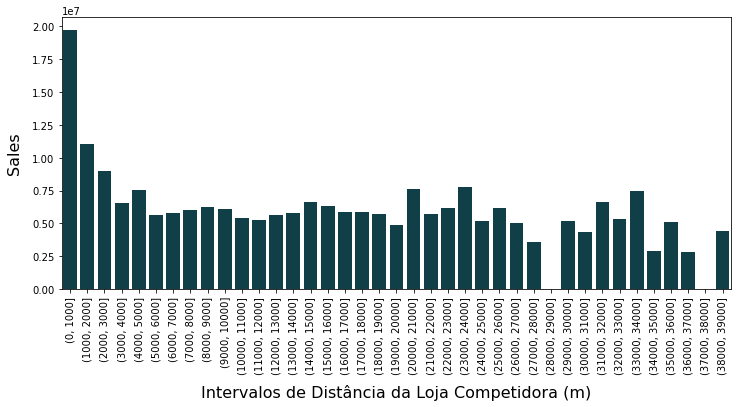

In [212]:
# Gráfico de Barras para podemor comparar a somatória das vendas por conjunto de competidores em certas distância
aux2 = df1[['CompetitionDistance', 'Sales']].groupby(
    'CompetitionDistance').sum().reset_index()
bins = list(np.arange(0, 40000, 1000))
aux2['CompetitionDistanceBinned'] = pd.cut(
    aux2['CompetitionDistance'], bins=bins)
aux3 = aux2[['CompetitionDistanceBinned', 'Sales']].groupby(
    'CompetitionDistanceBinned').mean().reset_index()
sns.barplot(x='CompetitionDistanceBinned',
            y='Sales', data=aux3, color='#074650')
plt.xlabel('Intervalos de Distância da Loja Competidora (m)', labelpad=10, fontsize=16)
plt.ylabel('Sales', labelpad=10, fontsize=16)
plt.xticks(rotation=90);

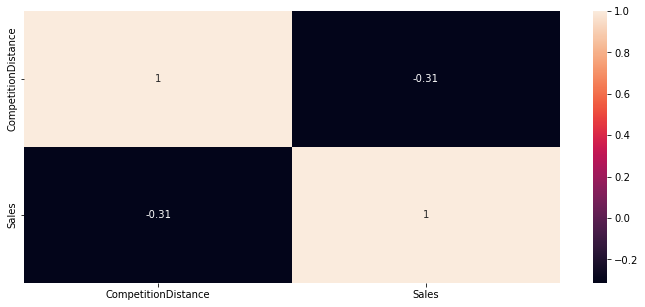

In [213]:
# Heatmap para mensurar a Correlação entre Sales e Competition Distance
sns.heatmap(aux2.corr(method='pearson'), annot=True);

## Lojas com promoções ativas por mais tempo vendem mais

As vendas podem aumentar durante campanhas de marketing e promoções, como liquidações de estoque 
ou descontos em compras.

In [216]:
df1[['Promo','Promo2','Sales']].groupby(['Promo', 'Promo2']).agg({'Sales': ['mean']}).stb.flatten()

,Promo,Promo2,Sales_mean
0,0,0,4722.19
1,0,1,4091.11
2,1,0,8393.78
3,1,1,7588.42


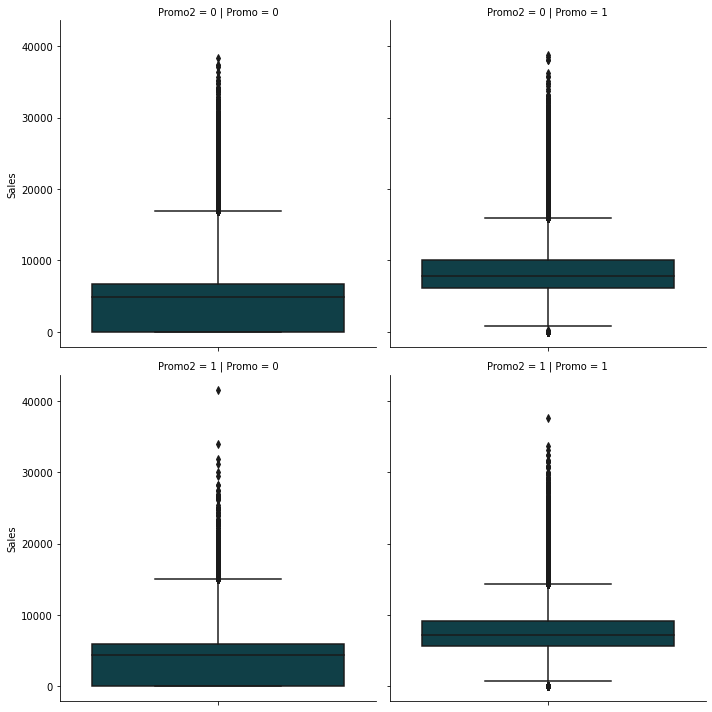

In [221]:
sns.catplot(y='Sales', data=df1, kind='box',
            col='Promo', row='Promo2', color='#074650')

## Feriados Escolares X Vendas

Text(0.5, 1.0, 'Boxplot com outliers omitidos')

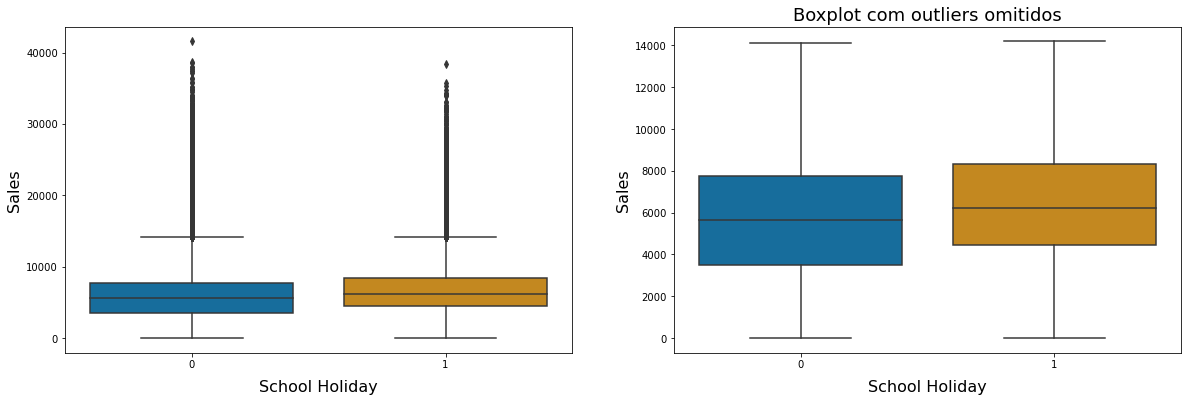

In [30]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))
# State Holiday
sns.boxplot(x='SchoolHoliday', y='Sales', data=df1,
            palette='colorblind', ax=ax0)
ax0.set_xlabel('School Holiday', labelpad=10, fontsize=16)
ax0.set_ylabel('Sales', fontsize=16)

# State Holiday sem outliers
sns.boxplot(x='SchoolHoliday', y='Sales', data=df1,
            palette='colorblind', sym='', ax=ax1)
ax1.set_xlabel('School Holiday', labelpad=10, fontsize=16)
ax1.set_ylabel('Sales', fontsize=16)
ax1.set_title('Boxplot com outliers omitidos', fontsize=18)

## Feriados Estaduais X Vendas

Text(0.5, 1.0, 'Boxplot com outliers omitidos')

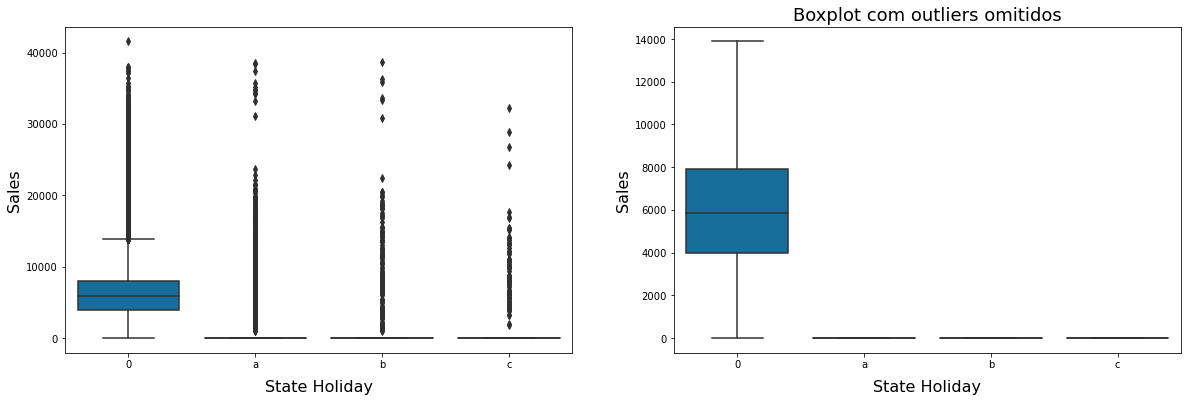

In [25]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))
# State Holiday
sns.boxplot(x='StateHoliday', y='Sales', data=df1,
            palette='colorblind', ax=ax0)
ax0.set_xlabel('State Holiday', labelpad=10, fontsize=16)
ax0.set_ylabel('Sales', fontsize=16)

# State Holiday sem outliers
sns.boxplot(x='StateHoliday', y='Sales', data=df1,
            palette='colorblind', sym='', ax=ax1)
ax1.set_xlabel('State Holiday', labelpad=10, fontsize=16)
ax1.set_ylabel('Sales', fontsize=16)
ax1.set_title('Boxplot com outliers omitidos', fontsize=18)

## Dia da Semana X Vendas

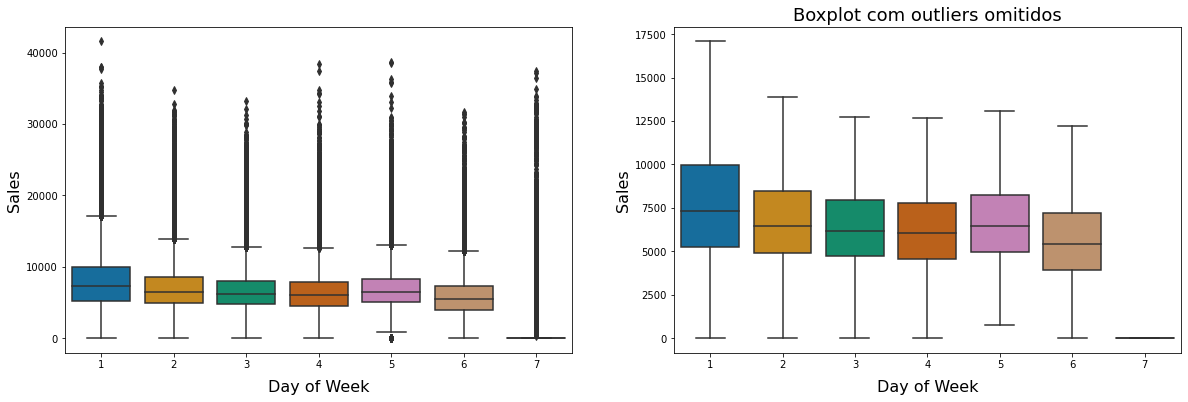

In [26]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

# Day of Week
sns.boxplot(x='DayOfWeek', y='Sales', data=df1, palette='colorblind', ax=ax0)
ax0.set_xlabel('Day of Week', labelpad=10, fontsize=16)
ax0.set_ylabel('Sales', fontsize=16)

# Day of Week com omissão dos outliers
sns.boxplot(x='DayOfWeek', y='Sales', data=df1, palette='colorblind', sym='', ax=ax1)
ax1.set_xlabel('Day of Week', labelpad=10, fontsize=16)
ax1.set_ylabel('Sales', fontsize=16)
ax1.set_title('Boxplot com outliers omitidos', fontsize=18);